<html><h1>Time series testing</h1></html>
This was the first notebook I started to explore FEC data. This isn't a very neat notebook, it's not at all optimized and there are few annotations. Much of the code in here was improved upon or imported to other notebooks, and there are some interesting things in here I think.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import datetime
from urllib.request import urlopen

In [2]:
#entries
csv_path=r"csvs\cunningham-nc-sen-receipts-2019-2020.csv"
select_quarter='Q3' ## if interested in looking at specific quarter: Input 'YE' for Q4 info
select_year=2020 ## if only interested in a specific year
# start_date=
# end_date=
# start_date=2020,9,1# start date as year,month,day - if a quarter is input then these days will automatically be set
# end_date=2020,11,3              # end date
# interval='1D' ## if you want to smooth out the data/reduce noise you can add an interval here ('1D','3D','1W', etc.) and 
# side='right'

# #conversions
# start_date=datetime.date(start[0],start[1],start[2])
# end_date=datetime.date(end[0],end[1],end[2])

In [3]:
fundraising_raw=pd.read_csv(csv_path, low_memory=False)
print(fundraising_raw['committee_name'].head(1).iloc[0].title())

fundraising_raw['receipt_date'] = pd.to_datetime(fundraising_raw['contribution_receipt_date']).dt.date
fundraising_raw['receipt_year'] = pd.DatetimeIndex(fundraising_raw['receipt_date']).year
fundraising_raw['receipt_month'] = pd.DatetimeIndex(fundraising_raw['receipt_date']).month
fundraising_raw['receipt_time'] = pd.to_datetime(fundraising_raw['contribution_receipt_date']).dt.time

fundraising_shrink=fundraising_raw[['report_year','report_type','entity_type_desc','contributor_name'
    ,'contributor_first_name','contributor_middle_name','contributor_last_name','contributor_suffix','contributor_street_1'
    ,'contributor_street_2','contributor_city','contributor_state','contributor_zip','contributor_employer'
    ,'contributor_occupation','receipt_date','receipt_year','receipt_month','receipt_time','contribution_receipt_amount','contributor_aggregate_ytd',
    'donor_committee_name','election_type','schedule_type_full']]


Cal For Nc


this section deals with data from a specific quarter

In [4]:
fundraising_shrink['report_type'].unique()

array(['30G', 'Q1', 'Q2', 'Q3', '12G', 'YE', '12P'], dtype=object)

In [5]:
#for pulling data on a specific quarter in a specific year

filter1=fundraising_shrink['report_type']==select_quarter  # 'Q1','Q2','Q3','YE' for Q4
# filter2=fundraising_shrink1['receipt_year']==2019 # does it run faster to create year column or run below each time?
filter2=pd.DatetimeIndex(fundraising_shrink['receipt_date']).year==select_year

# #UPGRADED
# raised_quarter=fundraising_shrink1[['receipt_date','contribution_receipt_amount']].where(
#                                     filter1 & filter2
#                                     ) \
#                                     .groupby('receipt_date').sum()

raised_quarter=fundraising_shrink[(filter1 & filter2)][['receipt_date','contribution_receipt_amount']] \
                .groupby('receipt_date').sum()
raised_quarter.reset_index(inplace=True)

# count_quarter=fundraising_shrink1[['receipt_date','contributor_first_name']].where(
#                                     filter1 & filter2
#                                     ) \
#                                     .groupby('receipt_date').count()

count_quarter=fundraising_shrink[(filter1 & filter2)][['receipt_date','contribution_receipt_amount']] \
                .groupby('receipt_date').count()
count_quarter.rename(columns={'contribution_receipt_amount':'count'}, inplace=True)
count_quarter.reset_index(inplace=True)

# raised_on_date=raised_on_date.drop(pd.to_datetime('2018-09-14'))

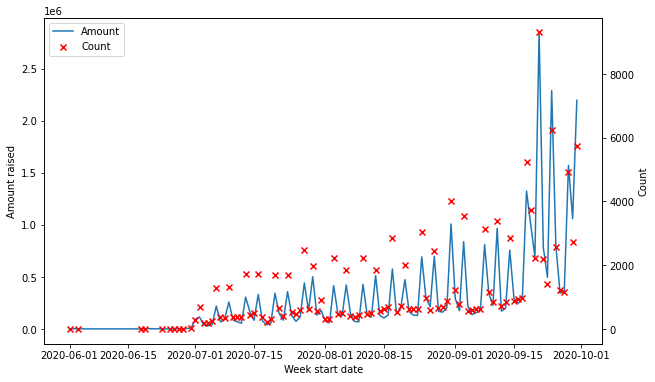

In [6]:
# plots
fig,ax=plt.subplots(figsize=(10,6))    # figure out how to change the figure size later on, if using multiple subplots you
ax2=ax.twinx()                         # want to be able to adjust each subplot separately


ax.set_xlabel('Week start date')

ax.plot(raised_quarter['receipt_date'],raised_quarter['contribution_receipt_amount'],label='Amount')
ax.set_ylabel('Amount raised')
    
ax2.scatter(count_quarter['receipt_date'],count_quarter['count'],color='r',marker='x',label='Count')
ax2.set_ylabel('Count')
# ax.legend(['Count'],loc='upper left')



# ax2.legend(['Amount'],loc='upper left')

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2,loc='upper left')



The following cells relate to working with data from a specific date range

In [7]:
#for selecting between specified dates

start=2020,9,1# start date as year,month,day
end=2020,11,3              # end date
interval='4D'
side='right'

start=datetime.date(start[0],start[1],start[2])
end=datetime.date(end[0],end[1],end[2])


raised_between=fundraising_shrink[['receipt_date','contribution_receipt_amount']].groupby('receipt_date').sum()
raised_between.reset_index(inplace=True)
raised_between=raised_between[(raised_between['receipt_date']>start) & 
                                   (raised_between['receipt_date']<=end)]
raised_between['receipt_date'] = pd.to_datetime(raised_between['receipt_date'])

count_between=fundraising_shrink[['receipt_date','contributor_first_name']].groupby('receipt_date').count()
count_between.rename(columns={'contributor_first_name':'count'}, inplace=True)
count_between.reset_index(inplace=True)
count_between=count_between[(count_between['receipt_date']>start) & 
                                   (count_between['receipt_date']<=end) ]

count_between['receipt_date'] = pd.to_datetime(count_between['receipt_date'])



weekly_raising = raised_between.groupby(pd.Grouper(key='receipt_date', freq=interval, closed=side, label=side)
                                     )['contribution_receipt_amount'].sum().reset_index().sort_values('receipt_date')
weekly_count =count_between.groupby(pd.Grouper(key='receipt_date', freq=interval, closed=side, label=side)
                                     )['count'].sum().reset_index().sort_values('receipt_date')



Text(15, 25, 'BBQ misfire\n09-28')

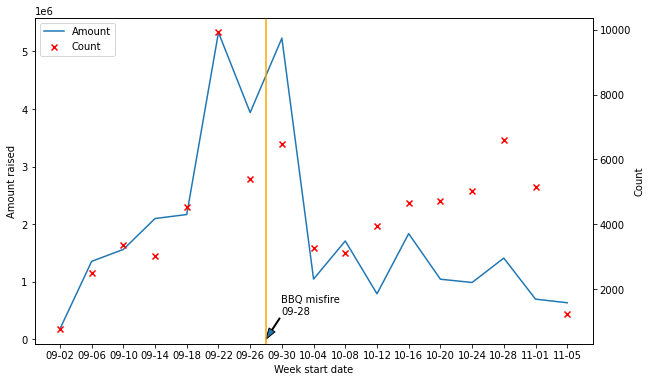

In [8]:
# plots
fig2,ax=plt.subplots(figsize=(10,6))    # figure out how to change the figure size later on, if using multiple subplots you
ax2=ax.twinx()                         # want to be able to adjust each subplot separately

ax.set_xlabel('Week start date') 
    
ax2.scatter(weekly_count['receipt_date'],weekly_count['count'],color='r',marker='x',label='Count')
ax2.set_ylabel('Count')

# ax.legend(['Count'],loc='upper left')


ax.plot(weekly_raising['receipt_date'],weekly_raising['contribution_receipt_amount'],label='Amount')
ax.set_ylabel('Amount raised')
# ax2.legend(['Amount'],loc='upper left')


ax.set_xticks(weekly_raising.receipt_date)
ax.set_xticklabels(weekly_raising.receipt_date.dt.strftime('%m-%d')
                   ,fontdict={'fontsize':10
#                               ,'color':'pink'
                               }
                  )

lines, labels = ax.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax.legend(lines + lines2, labels + labels2,loc='upper left')


# labs = [l.get_label() for l in lns]
# ax.legend(lns, labs, loc=0)

###for plotting a vertical line at the time of an event worth investigating
event=datetime.date(2020,9,28)
plt.axvline(x=event,color='orange')
xy=(event,0)
ax.annotate('BBQ misfire\n' + event.strftime('%m-%d'),xy=xy
           ,xytext=(15,25),textcoords='offset points'
           ,arrowprops={'width':1
                        ,'headwidth':7
                        ,'headlength':11
                       }
           )





##REPLACED
#event=2020,9,28
# vert=datetime.date(event[0],event[1],event[2])
# plt.axvline(x=datetime.date(event[0],event[1],event[2]), color='r')



This next section deals with donations geographically. I'll break down the donors by state, zipcode, and city

In [9]:
fundraising_shrink[['contributor_zip','contributor_city','contributor_state']].groupby('contributor_city').head()

,contributor_zip,contributor_city,contributor_state
0,606116457,CHICAGO,IL
1,830149602,WILSON,WY
2,940276456,ATHERTON,CA
3,940276456,ATHERTON,CA
4,125922551,WASSAIC,NY
...,...,...,...
254875,922109184,INDIAN WELLS,CA
255018,207722675,UPPER MARLBORO,MD
255143,109010449,SUFFERN,NY
255146,287190455,CHEROKEE,NC


In [ ]:
# #OLD VERSION OF QUARTERLY PLOT, REPLACED TO BE MORE CONSISTENT WITH DATE PLOT

# fig,ax1=plt.subplots(sharex=True)

# # fig.__init__(,figsize=(10,6))


# raised_on_quarter.plot('receipt_date','contribution_receipt_amount',figsize=(10,6),ax=ax1,label='Amount')
# ax1.set_xlabel('Receipt Date')
# ax1.set_ylabel('Total raised')

# ax2=ax1.twinx()
# count_quarter.plot.scatter('receipt_date','count',ax=ax2,color='r',label='count')
# ax2.set_ylabel('Count')


# lines, labels = ax.get_legend_handles_labels()
# lines2, labels2 = ax2.get_legend_handles_labels()
# ax2.legend(lines + lines2, labels + labels2,loc='upper left')

In [ ]:
# #for plotting with index instead of x column

# plt.scatter(weekly_count.index,weekly_count['count'])
# plt.plot(weekly_raising.index,weekly_raising['contribution_receipt_amount'])